## Grammar-Checker

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
import warnings
warnings.filterwarnings('ignore')
# from google.colab import drive
# drive.mount("/content/drive")

Found GPU at: /device:GPU:0


In [2]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Installing Hugging-Face


Installing the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT.



In [3]:
!pip install transformers

## Downloading the Dataset


We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset.


In [4]:
!pip install wget
import wget
import os
url = 'https://aman30865.github.io/cola_public_1.1.zip' #dataset hosted on my github
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

##  Parsing the dataset Using Pandas

In [5]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
sentences = df.sentence.values
labels = df.label.values
df.head(5)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


## Preprocessing

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [6]:
#Loading the tokenizer for preprocessing
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print("Done")

Loading BERT tokenizer...
Done


## Tokenize the dataset

In [7]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences to 64 tokens.
                        truncation = True,
                        padding='max_length',
                        pad_to_max_length = True,
                        return_attention_mask = True,   # add attention masks.
                        return_tensors = 'pt',
                   )   
    #making list of ids and masks
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[6])
print('Token IDs:', input_ids[6])

Original:  Fred watered the plants flat.
Token IDs: tensor([  101,  5965, 27129,  1996,  4264,  4257,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## Splitting Dataset for training and validation


Spliting our training set to use 90% for training and 10% for validation.

In [8]:

from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


Using the torch DataLoader class that helps to save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [9]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
#for training
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
# for validation
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )



We have pre-trained BERT model and the additional untrained classification layer that will be trained and fined tuned according to out task. 


In [10]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer BERT model
    num_labels = 2,    
    output_attentions = False,
    output_hidden_states = False,
)
#use GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Hyperparameter Tuning

Setting the Adam optimizer and parameters as-
>- **Batch size:** 32  
- **Learning rate:** 2e-5  
- **Number of epochs:** 4 

In [11]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


In [12]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Define a helper function for calculating accuracy.

In [13]:
import numpy as np

# Function to calculate the accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [14]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Training our model

In [15]:
import random
import numpy as np
seed_val = 34

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()
#TRAINING
# For each epoch
for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} ========'.format(epoch_i + 1))

    t0 = time.time()
    total_train_loss = 0

    model.train()

    # For each batch 
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # VALIDATION
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 ========

  Average training loss: 0.50
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.46
  Validation took: 0:00:03

======== Epoch 2 ========

  Average training loss: 0.31
  Training epcoh took: 0:01:25

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.51
  Validation took: 0:00:03

======== Epoch 3 ========

  Average training loss: 0.20
  Training epcoh took: 0:01:26

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.53
  Validation took: 0:00:03

======== Epoch 4 ========

  Average training loss: 0.14
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.60
  Validation took: 0:00:03

Training complete!
Total training took 0:05:53 (h:mm:ss)


## Summary of the training process.

In [16]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.46,0.78,0:01:21,0:00:03
2,0.31,0.51,0.80,0:01:25,0:00:03
3,0.20,0.53,0.81,0:01:26,0:00:03
4,0.14,0.60,0.81,0:01:27,0:00:03


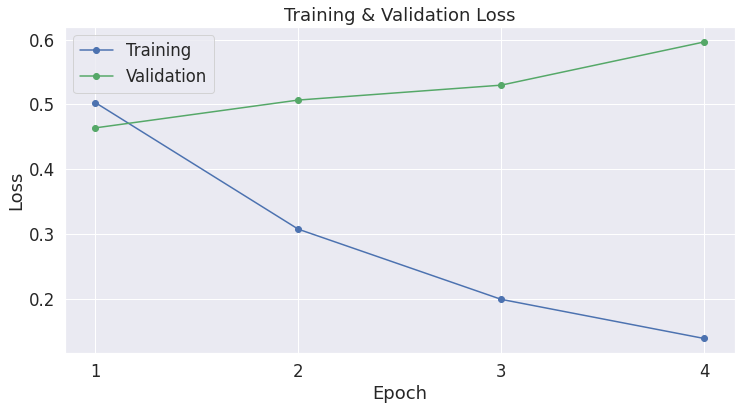

In [17]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance On Test Set

### Data Preparation


Test data preparation

In [18]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df.sentence.values
labels = df.label.values
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True, 
                        max_length = 64,          
                        truncation =True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt', 
                   )  
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



##  Evaluate on Test Set


Generating predictions on the test set.


In [19]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 516 test sentences...
DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [20]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

matthews_set = []


print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Calculating Matthews Corr. Coef. for each batch...
Total MCC: 0.519


##  Saving


In [21]:
import os

output_dir = '/content/saved_model'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) #Creating required directory
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/saved_model/vocab.txt',
 '/content/saved_model/special_tokens_map.json',
 '/content/saved_model/added_tokens.json')

## Prediction

In [22]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch

output_dir = '/content/saved_model' # or https://drive.google.com/drive/folders/1gBtM3ifYsrZ70ZmNW1hj-pb-dxvd2n3b?usp=sharing
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

In [24]:
again = 1
while(again):
  sent = input()
  encoded_dict = tokenizer.encode_plus(
                          sent,
                          add_special_tokens = True,
                          max_length = 64,
                          truncation=True,
                          padding='max_length',
                          return_attention_mask = True,
                          return_tensors = 'pt',
                    )
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  input_id = torch.LongTensor(input_id)
  attention_mask = torch.LongTensor(attention_mask)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_loaded = model_loaded.to(device)
  input_id = input_id.to(device)
  attention_mask = attention_mask.to(device)
  with torch.no_grad():
    outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)
  logits = outputs[0]
  index = logits.argmax()
  if index == 1:
    print("The given sentence is Gramatically correct")
  else:
    print("The given sentence is Gramatically in-correct")
  again=int(input("Enter 1 to Continue or 0 to Exit:"))


I am going
The given sentence is Gramatically correct
Enter 1 to Continue or 0 to Exit:1
I am go
The given sentence is Gramatically in-correct
Enter 1 to Continue or 0 to Exit:0
